In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Step 2

In [2]:
df_dnm = pd.read_csv("aau1043_dnm.tsv")
df_parental_age = pd.read_csv("aau1043_parental_age.tsv")

In [3]:
df_dnm

,Chr,Pos,Ref,Alt,Proband_id,Phase_combined,Crossover,Sanger
0,chr1,241097646,C,T,99379,father,paternal_crossover,confirmed
1,chr10,29202943,A,G,8147,father,maternal_crossover,PCR failed
2,chr11,129441657,C,T,5410,mother,maternal_crossover,confirmed
3,chr13,96867147,A,G,46025,father,paternal_crossover,confirmed
4,chr17,50609998,C,T,144769,mother,maternal_crossover,confirmed
...,...,...,...,...,...,...,...,...
26426,chr9,137374330,C,T,54383,father,NaN,NaN
26427,chr9,137396508,C,T,39729,father,NaN,NaN
26428,chr9,137633973,C,A,17904,mother,NaN,NaN
26429,chr9,137889777,G,A,80108,father,NaN,NaN


In [4]:
df_parental_age

,Proband_id,Father_age,Mother_age
0,675,31,36
1,1097,19,19
2,1230,30,28
3,1481,32,20
4,1806,38,34
...,...,...,...
391,153657,27,23
392,154565,36,30
393,154621,19,18
394,154810,32,28


# Step 3

In [5]:
proband_count = {}

for row in df_dnm.itertuples():
    proband_id = row[5]
    phase_combined = row[6]
    
    proband_count.setdefault(proband_id, [0,0,0])
    
    proband_count[proband_id][2] += 1
    
    if phase_combined == "father":
        proband_count[proband_id][0] += 1
    elif phase_combined == "mother":
        proband_count[proband_id][1] += 1

In [6]:
df_dnm_count = pd.DataFrame(columns = ["Proband_id", "pat_dnm", "mat_dnm", "tot_dnm"])
for proband_id, counts in proband_count.items():
    df_dnm_count = df_dnm_count.append({
        "Proband_id": proband_id,
        "pat_dnm": counts[0],
        "mat_dnm": counts[1],
        "tot_dnm": counts[2]
    }, ignore_index=True)
    
df_dnm_count

,Proband_id,pat_dnm,mat_dnm,tot_dnm
0,99379,38,8,47
1,8147,78,27,114
2,5410,52,16,70
3,46025,40,11,52
4,144769,49,13,63
...,...,...,...,...
391,36485,44,7,51
392,19715,40,9,52
393,131854,48,7,58
394,67028,31,7,38


# Step 4

In [7]:
df_dnm_age = df_parental_age.merge(df_dnm_count)

#right now the counts are object types
#they must be converted to integer types for modeling
df_dnm_age = df_dnm_age.astype({
    'pat_dnm': 'int64',
    'mat_dnm': 'int64',
    'tot_dnm': 'int64'
})

df_dnm_age

,Proband_id,Father_age,Mother_age,pat_dnm,mat_dnm,tot_dnm
0,675,31,36,51,19,70
1,1097,19,19,26,12,39
2,1230,30,28,42,12,57
3,1481,32,20,53,14,68
4,1806,38,34,61,11,78
...,...,...,...,...,...,...
391,153657,27,23,41,8,49
392,154565,36,30,61,14,75
393,154621,19,18,39,11,50
394,154810,32,28,55,14,69


# Step 5

In [8]:
xp = df_dnm_age.loc[:,"Father_age"][1:]
yp = df_dnm_age.loc[:,"pat_dnm"][1:]

xm = df_dnm_age.loc[:,"Mother_age"][1:]
ym = df_dnm_age.loc[:,"mat_dnm"][1:]

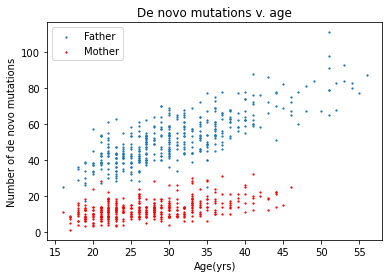

In [9]:
fig, ax = plt.subplots()
ax.scatter(xp, yp, label="Father", s=1.5)
ax.scatter(xm, ym, color="red", label="Mother", s=1.5)

ax.set_title("De novo mutations v. age")
ax.set_xlabel("Age(yrs)")
ax.set_ylabel("Number of de novo mutations")
ax.legend()

# Step 6

In [10]:
mat_model = smf.ols(formula = "mat_dnm ~ 1 + Mother_age", data = df_dnm_age)
mat_results = mat_model.fit()
mat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mat_dnm   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     116.0
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           6.88e-24
Time:                        20:36:28   Log-Likelihood:                -1158.1
No. Observations:                 396   AIC:                             2320.
Df Residuals:                     394   BIC:                             2328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5040      0.981      2.553      0.011       0.576       4.432
Mother_age     0.3776      0.035     10.772      0.000       0.309       0.446
==============================================================================
Omnibus:                       51.143   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.501
Skew:                           0.845   Prob(JB):                     4.03e-17
Kurtosis:                       4.310   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
mat_results.pvalues

Intercept     1.104177e-02
Mother_age    6.878208e-24
dtype: float64

The relationship mat_dnm v. Mother_age is significant (p-value close to 0)

The size of the relationship is 0.3776 (about 1 additional mutation every 2-3 years of age of the mother)

# Step 7

In [12]:
pat_model = smf.ols(formula = "pat_dnm ~ 1 + Father_age", data = df_dnm_age)
pat_results = pat_model.fit()
pat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pat_dnm   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     639.6
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           1.55e-84
Time:                        20:36:28   Log-Likelihood:                -1406.6
No. Observations:                 396   AIC:                             2817.
Df Residuals:                     394   BIC:                             2825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3263      1.702      6.066      0.000       6.979      13.673
Father_age     1.3538      0.054     25.291      0.000       1.249       1.459
==============================================================================
Omnibus:                        7.687   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                8.185
Skew:                           0.256   Prob(JB):                       0.0167
Kurtosis:                       3.483   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
pat_results.pvalues

Intercept     3.079437e-09
Father_age    1.552294e-84
dtype: float64

The relationship pat_dnm v. Father_age is significant (pval close to 0)

The size of the relationship is 1.3538 (about 2 additional paternally inherited de novo mutation per year of age of the father)

# Step 8

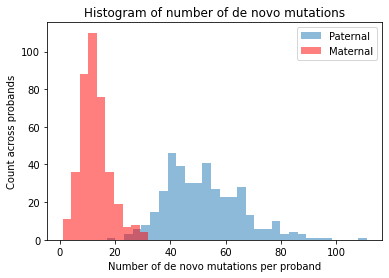

In [14]:
fig,ax = plt.subplots()
ax.hist(df_dnm_age.loc[:,"pat_dnm"][1:], alpha = 0.5, label = "Paternal", bins = 30)
ax.hist(df_dnm_age.loc[:,"mat_dnm"][1:], color = "red", alpha = 0.5, label = "Maternal")

ax.set_title("Histogram of number of de novo mutations")
ax.set_xlabel("Number of de novo mutations per proband")
ax.set_ylabel("Count across probands")
ax.legend()

plt.show()

# Step 9

In [15]:
stats.ttest_ind(df_dnm_age.loc[:,"pat_dnm"][1:], 
               df_dnm_age.loc[:,"mat_dnm"][1:])

Ttest_indResult(statistic=53.30597513071407, pvalue=1.435337370692767e-263)

The difference in number of de novo mutations per proband maternally and paternally inherited is significant (p-val is near 0)

The dataframe is not structured in a way that a sfm.ols model can be made. "paternal" and "maternal" inheritance would need to be row values next to number of de novo mutations per proband, rather than column titles:

proband_id, dnms, inheritance

In [16]:
dict_dnm_hist = {
    "proband_id":[],
    "num_dnms":[],
    "inheritance":[]
}

for row in df_dnm_age.itertuples():
    proband_id = row[1]
    pat_dnm = row[4]
    mat_dnm = row[5]
    
    dict_dnm_hist["proband_id"].append(proband_id)
    dict_dnm_hist["num_dnms"].append(pat_dnm)
    dict_dnm_hist["inheritance"].append("paternal")
    
    dict_dnm_hist["proband_id"].append(proband_id)
    dict_dnm_hist["num_dnms"].append(mat_dnm)
    dict_dnm_hist["inheritance"].append("maternal")

In [17]:
df_dnm_hist = pd.DataFrame(data=dict_dnm_hist)
df_dnm_hist

,proband_id,num_dnms,inheritance
0,675,51,paternal
1,675,19,maternal
2,1097,26,paternal
3,1097,12,maternal
4,1230,42,paternal
...,...,...,...
787,154621,11,maternal
788,154810,55,paternal
789,154810,14,maternal
790,154936,36,paternal


In [18]:
hist_model = smf.ols(formula = "num_dnms ~ 1 + inheritance", data = df_dnm_hist)
hist_results = hist_model.fit()
hist_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_dnms   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2852.
Date:                Thu, 02 Sep 2021   Prob (F-statistic):          2.20e-264
Time:                        20:36:28   Log-Likelihood:                -2972.8
No. Observations:                 792   AIC:                             5950.
Df Residuals:                     790   BIC:                             5959.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  12.7803      0.520     24.601      0.000      11.761      13.800
inheritance[T.paternal]    39.2348      0.735     53.404      0.000      37.793      40.677
==============================================================================
Omnibus:                      133.813   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              374.697
Skew:                           0.850   Prob(JB):                     4.32e-82
Kurtosis:                       5.910   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
hist_results.pvalues

Intercept                   1.156747e-99
inheritance[T.paternal]    2.198603e-264
dtype: float64

I don't know exactly why the ttest results for the the stats.ttest_ind() and the smf.ols() are different, but both suggest significant differences, with paternal dfms being greater in number than maternal

# Step 10

In [20]:
#Step 6
mat_model = smf.poisson(formula = "mat_dnm ~ 1 + Mother_age", data = df_dnm_age)
mat_results = mat_model.fit()
mat_results.summary()

Optimization terminated successfully.
         Current function value: 2.927974
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                mat_dnm   No. Observations:                  396
Model:                        Poisson   Df Residuals:                      394
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                 0.07164
Time:                        20:36:28   Log-Likelihood:                -1159.5
converged:                       True   LL-Null:                       -1248.9
Covariance Type:            nonrobust   LLR p-value:                 8.241e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7671      0.060     29.235      0.000       1.649       1.886
Mother_age     0.0281      0.002     13.582      0.000       0.024       0.032
==============================================================================
"""

In [21]:
#Step 7
pat_model = smf.poisson(formula = "pat_dnm ~ 1 + Father_age", data = df_dnm_age)
pat_results = pat_model.fit()
pat_results.summary()

Optimization terminated successfully.
         Current function value: 3.578620
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                pat_dnm   No. Observations:                  396
Model:                        Poisson   Df Residuals:                      394
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.2277
Time:                        20:36:28   Log-Likelihood:                -1417.1
converged:                       True   LL-Null:                       -1834.9
Covariance Type:            nonrobust   LLR p-value:                1.004e-183
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1903      0.027    116.856      0.000       3.137       3.244
Father_age     0.0241      0.001     29.608      0.000       0.023       0.026
==============================================================================
"""

In [22]:
#Step 9
hist_model = smf.poisson(formula = "num_dnms ~ 1 + inheritance", data = df_dnm_hist)
hist_results = hist_model.fit()
hist_results.summary()

Optimization terminated successfully.
         Current function value: 3.893765
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               num_dnms   No. Observations:                  792
Model:                        Poisson   Df Residuals:                      790
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.6206
Time:                        20:36:28   Log-Likelihood:                -3083.9
converged:                       True   LL-Null:                       -8128.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.5479      0.014    181.260      0.000       2.520       2.575
inheritance[T.paternal]     1.4036      0.016     89.467      0.000       1.373       1.434
===========================================================================================
"""

# Step 11

In [23]:
observations = pd.DataFrame({
    "Father_age": [50.5]
})

In [24]:
pat_results.predict(observations)

0    82.031316
dtype: float64

The Poisson regression of pat_dnm v. Father age predicts about 82 paternally inherited de novo mutations from a father of age 50.5.